In [18]:
%pylab nbagg
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.colors as mcolors
from scipy import stats
from scipy.stats import rankdata
import pickle
import mne
import os
current_path = os.getcwd()

Populating the interactive namespace from numpy and matplotlib


In [20]:
red_color = plt.cm.Reds(0.6)

In [21]:
import pickle

file_path = '../data/SEEG/sub1/sub-01_run-01_Radius-100_metrics.pkl'

# Open the file in 'rb' mode (read binary)
with open(file_path, 'rb') as file:
    data_1 = pickle.load(file)

In [22]:
Entrainment_post=list(data_1['metrics_post']['phase_coherence_matrix_mean_mat'].values())

In [23]:
Entrainment_pre=list(data_1['metrics_pre']['phase_coherence_matrix_mean_mat'].values())

In [24]:
stats.spearmanr(Entrainment_pre, Entrainment_post)

SpearmanrResult(correlation=0.602251407129456, pvalue=3.930544007049036e-05)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


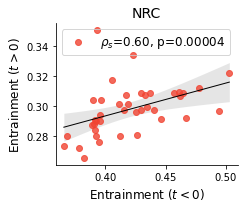

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Convert to numpy arrays
x = np.asarray(Entrainment_pre, dtype=float)
y = np.asarray(Entrainment_post, dtype=float)

# --- Stats: Spearman for correlation, OLS for line + CI ---
rho, rho_p = stats.spearmanr(x, y)

# Ordinary least squares line
lr = stats.linregress(x, y)
slope, intercept = lr.slope, lr.intercept

# Residual std. error
y_hat = intercept + slope * x
resid = y - y_hat
n = x.size
df = n - 2
s = np.sqrt(np.sum(resid**2) / df)

# Grid for smooth line/band
x_grid = np.linspace(x.min(), x.max(), 200)
y_grid = intercept + slope * x_grid

# 95% CI for the mean regression line
x_bar = x.mean()
Sxx = np.sum((x - x_bar)**2)
tcrit = stats.t.ppf(0.975, df)
se_mean = s * np.sqrt(1/n + (x_grid - x_bar)**2 / Sxx)
ci_upper = y_grid + tcrit * se_mean
ci_lower = y_grid - tcrit * se_mean

# --- Plot (same style as yours) ---
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

plt.figure(figsize=(3.5, 3))
plt.title('NRC', fontsize=14)

# Confidence band
plt.fill_between(x_grid, ci_lower, ci_upper, alpha=0.2, color="gray", linewidth=0)

# Scatter
plt.scatter(
    x, y,
    label=rf'$\rho_s$={rho:.2f}, p={rho_p:.5f}',
    alpha=0.8,
    c=red_color
)

# Regression line
plt.plot(x_grid, y_grid, color="black", linewidth=1, zorder=3)

plt.legend(fontsize=12, facecolor='none', loc='upper left')
# plt.ylim(1.2, 2.)  # left commented, like your code

plt.xlabel('Entrainment ($t<0$)', fontsize=12)
plt.ylabel('Entrainment ($t>0$)', fontsize=12)

plt.tight_layout()

#plt.savefig(path_fig_out + 'EEG_Entrainment_scatter.png', dpi=300, transparent=True)
plt.show()


# Surrogates

In [27]:
import pickle

file_path_s = '../data/SEEG/sub1/sub-01_run-01_Radius-100_metrics_surrogate.pkl' #sub-03_run-08_100_metrics.pkl'#

# Open the file in 'rb' mode (read binary)
with open(file_path_s, 'rb') as file:
    data_1_s = pickle.load(file)

In [28]:
data_1_s['metrics_pre_surr'].keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [29]:
observed_corr=stats.spearmanr(Entrainment_pre, Entrainment_post)[0]
null_corrs=np.zeros(100)
for i in range(100):
    A=list(data_1_s['metrics_pre_surr'][i]['phase_coherence_matrix_mean_mat'].values())
    B=list(data_1_s['metrics_post_surr'][i]['phase_coherence_matrix_mean_mat'].values())
    null_corrs[i]=stats.spearmanr(A,B)[0]

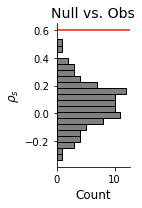

In [30]:
fig, ax = plt.subplots(figsize=(2, 3))
ax.hist(null_corrs, bins=20, orientation='horizontal', color='gray', edgecolor='black')

# Add vertical line for observed correlation
ax.axhline(observed_corr, color=red_color, alpha=0.9, linewidth=2)

# Label axes
ax.set_xlabel("Count", fontsize=12)
ax.set_ylabel(r"$\rho_s$", fontsize=12)
ax.set_title("Null vs. Obs", fontsize=14)

plt.tight_layout()
plt.show()